In [2]:
### load data
from keras.datasets import boston_housing
(train_data,train_targets),(test_data,test_targets)=boston_housing.load_data()

In [3]:
###preprocess

#data normalization
mean=train_data.mean(axis=0)
train_data-=mean
std=train_data.std(axis=0)
train_data/=std

test_data-=mean
test_data/=std

In [4]:
###model

from keras import models,layers

def build_model():
    model=models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    # 
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

In [7]:
###k-fold 
import numpy as np

k=4
num_val_samples=len(train_data)//k
num_epochs=100
all_scores=[]

for i in range(k):
    print('processing fold # ',i)
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data=np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets=np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model=build_model()
    model.fit(partial_train_data,partial_train_targets,epochs=num_epochs,batch_size=1,verbose=0)
    val_mse,val_mae=model.evaluate(val_data,val_targets,verbose=0)
    all_scores.append(val_mae)
    

processing fold #  0
processing fold #  1
processing fold #  2
processing fold #  3


In [8]:
all_scores

[1.975878061634479, 2.7837937609984142, 2.6211525945380183, 2.365044073893292]

In [10]:
num_epochs=500
all_mae_histories=[]

for i in range(k):
    print('processing fold # ',i)
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data=np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets=np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model=build_model()
    history=model.fit(partial_train_data,partial_train_targets,
                      validation_data=(val_data,val_targets),
                      epochs=num_epochs,batch_size=1,verbose=0)
    mae_history=history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
   

processing fold #  0
processing fold #  1
processing fold #  2
processing fold #  3


In [20]:
#all_mae_histories

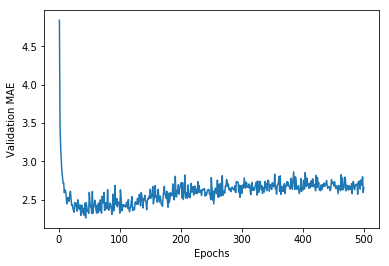

In [22]:
#calculate mean mae for all epoches
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

#plot
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
#average_mae_history

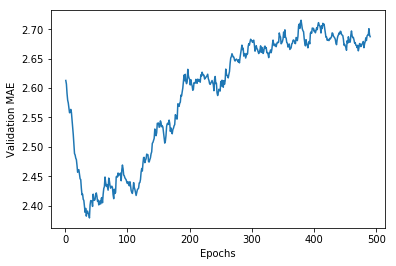

In [24]:
#delete first 10th data points 
def smooth_curve(points,factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
             smoothed_points.append(point)
    return smoothed_points

smooth_mae_history=smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smooth_mae_history)+1),smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [27]:
#train the final model with epoch=80,avoid overfitting

model=build_model()

model.fit(train_data,train_targets,epochs=80,batch_size=16,verbose=0)

test_mse_score,test_mae_score=model.evaluate(test_data,test_targets)


102/102 [==============================] - 0s 2ms/step


In [28]:
test_mse_score

16.310044531728707